# Kernel Ridge Regression
This notebook takes the full data scaled to zero mean and unit variance and the PCA reduced data and trains a Kernel Ridge Regressor for both datasets.

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

import numpy as np
import matplotlib.pyplot as plt
from src.kernels.rbf import RBFKernel
from src.models.kernel_ridge import KernelRidge

In [2]:
pca_data = np.load("../data/X_pca.npy")
scaled_data = np.load("../data/X_scaled.npy")
Y = np.load("../data/y.npy")

In [3]:
train_size = 8000

pca_train = pca_data[:train_size, :]
pca_val = pca_data[train_size:, :]
scaled_train = scaled_data[:train_size, :]
scaled_val = scaled_data[train_size:, :]
y_train = Y[:train_size]
y_val = Y[train_size:]

### Create RBF kernel function
Utillizes the fact that $(x-x')^2=||x||^2+||x'||^2-2x^Tx'$, 
https://www.youtube.com/watch?v=nJz_lazAUqw

In [4]:
kernel = RBFKernel(gamma=1.0)
model = KernelRidge(kernel=kernel, lambd=1e-2)
model.fit(scaled_train, y_train)
predictions = model.predict(scaled_val)
print("The absolute mean error is:", np.sum(np.abs(y_val - predictions))/ len(y_val))

The absolute mean error is: 12.217982961898688


In [9]:
def plot_predictions(y_val, y_pred):
    plt.figure(figsize=(8, 5))

    # Plot true values
    plt.plot(y_val, label="True values (y_val)", linewidth=2)

    # Plot predictions
    plt.plot(y_pred, label="Predictions", linewidth=2)

    plt.xlabel("Sample index")
    plt.ylabel("Value")
    plt.title("Predictions vs True Values")
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
best_gamma = None
best_lambda = None
best_MAE = np.inf
gamma_values = [0.01, 0.1, 1, 10]
lambda_values = [1e-3, 1e-2, 1e-1, 1]
for gamma in gamma_values:
    kernel = RBFKernel(gamma)
    for lambd in lambda_values:
        model = KernelRidge(kernel, lambd)
        model.fit(scaled_train, y_train)
        predictions = model.predict(scaled_val)
        mean_error = np.sum(np.abs(y_val - predictions))/ len(y_val)
        if mean_error < best_MAE:
            best_gamma = gamma
            best_lambda = lambd
            best_MAE = mean_error
print("The absolute mean error is:", best_MAE)

The absolute mean error is: 9.857950057617773


In [10]:
def train_krr(x, y, kernel, lambd):
    K = kernel(x, x)
    n = K.shape[0]
    return np.linalg.solve(K + lambd * np.eye(n), y)

def predict_krr(x_train, x_test, alpha, kernel):
    K = kernel(x_train, x_test)
    return K.T @ alpha

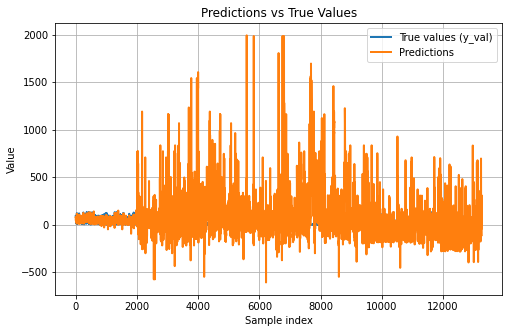

Best degree: 2
Best gamma: 0.1
Best coef0: 1.0
Best lambda: 1
The absolute mean error is: 111.2888699422081


In [11]:
import sys
sys.path.append("..")
from src.kernels.polynomial import PolynomialKernel

best_degree = None
best_gamma = None
best_coef0 = None
best_lambda = None
best_MAE = np.inf
best_predictions = None

degree_values = [2, 3, 4]
gamma_values = [0.1, 1]
coef0_values = [0.0, 1.0]
lambda_values = [1e-2, 1e-1, 1]

for degree in degree_values:
    for gamma in gamma_values:
        for coef0 in coef0_values:
            kernel = PolynomialKernel(degree=degree, gamma=gamma, coef0=coef0)
            for lambd in lambda_values:
                try:
                    alpha = train_krr(scaled_train, y_train, kernel, lambd)
                except np.linalg.LinAlgError:
                    n = scaled_train.shape[0]
                    K = kernel(scaled_train, scaled_train)
                    alpha = np.linalg.solve(K + (lambd + 1e-8) * np.eye(n), y_train)

                preds = predict_krr(scaled_train, scaled_val, alpha, kernel)
                mae = np.mean(np.abs(y_val - preds))

                if mae < best_MAE:
                    best_degree = degree
                    best_gamma = gamma
                    best_coef0 = coef0
                    best_lambda = lambd
                    best_MAE = mae
                    best_predictions = preds

plot_predictions(y_val, best_predictions)
print("Best degree:", best_degree)
print("Best gamma:", best_gamma)
print("Best coef0:", best_coef0)
print("Best lambda:", best_lambda)
print("The absolute mean error is:", best_MAE)

In [7]:
def train_krr(x, y, kernel, lambd):
    K = kernel(x, x)
    n = K.shape[0]
    return np.linalg.solve(K + lambd * np.eye(n), y)

def predict_krr(x_train, x_test, alpha, kernel):
    K = kernel(x_train, x_test)
    return K.T @ alpha

0.1 0.01 8.994605379093827
0.1 0.1 9.023504859770991
0.1 1 9.33045975464353
1 0.01 13.505907707447308
1 0.1 13.552273494244602
1 1 14.036834527601991


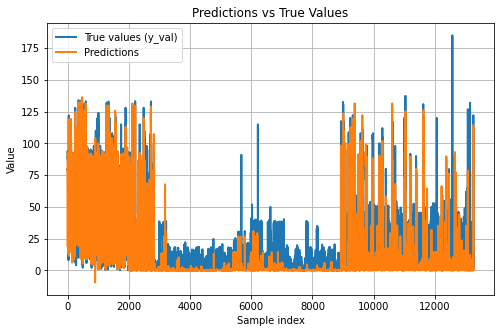

Best gamma: 0.1
Best lambda: 0.01
The absolute mean error is: 8.994605379093827


In [12]:
import sys
sys.path.append("..")

from src.kernels.laplacian import LaplacianKernel
import numpy as np

best_gamma = None
best_lambda = None
best_MAE = np.inf
best_predictions = None

gamma_values = [0.1, 1]
lambda_values = [1e-2, 1e-1, 1]

for gamma in gamma_values:
    kernel = LaplacianKernel(gamma=gamma)
    for lambd in lambda_values:
        try:
            alpha = train_krr(scaled_train, y_train, kernel, lambd)
        except np.linalg.LinAlgError:
            n = scaled_train.shape[0]
            K = kernel(scaled_train, scaled_train)
            alpha = np.linalg.solve(K + (lambd + 1e-8) * np.eye(n), y_train)

        preds = predict_krr(scaled_train, scaled_val, alpha, kernel)
        mae = np.mean(np.abs(y_val - preds))

        if mae < best_MAE:
            best_gamma = gamma
            best_lambda = lambd
            best_MAE = mae
            best_predictions = preds

        print(gamma, lambd, mae)

plot_predictions(y_val, best_predictions)
print("Best gamma:", best_gamma)
print("Best lambda:", best_lambda)
print("The absolute mean error is:", best_MAE)
